In [ ]:
!pip install yahoo_fin
!pip install requests_html


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.9/82.9 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.9/143.9 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 7.4 MB/s eta 0:00:00
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6047 sha256=d3a90a63f7a839b5f777a9cc3d2a153ea3429954d1bdc1ac5ff2be6381aa1e71
  Stored in directory: /root/.cache/pip/wheels/f0/69/93/a47e9d621be168e9e33c7ce60524393c0b92ae83cf6c6e89c5
Successfully built sgmllib3k
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.7
    Uninstalling urllib3-2.0.7:
      Successfully uninstalled urllib3-2.0.7


In [ ]:
import yfinance as yf
import pandas as pd
from yahoo_fin import stock_info as si
import requests
from bs4 import BeautifulSoup
import numpy as np

# Get the list of Nifty 50 stocks
nifty50_list = si.tickers_nifty50()
print("Tickers in Nifty 50:", len(nifty50_list))

# Fetch ESG scores
def get_esg_score(ticker):
    url = f"https://finance.yahoo.com/quote/{ticker}/sustainability"
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    esg_score_tag = soup.find('span', text='Sustainability')
    if esg_score_tag:
        esg_score = esg_score_tag.find_next_sibling('span').text
        return esg_score
    else:
        return None

# Fetch ESG scores for all Nifty 50 stocks
esg_scores = {}
for ticker in nifty50_list:
    esg_scores[ticker] = get_esg_score(ticker)
    print(f"Fetched ESG score for {ticker}: {esg_scores[ticker]}")

# Convert to DataFrame for easier viewing and manipulation
esg_df = pd.DataFrame(list(esg_scores.items()), columns=['Ticker', 'ESG Score'])

# Define a threshold for ethical approval
ethical_threshold = 50  # This threshold should be defined based on specific criteria

# Determine ethically approved stocks
esg_df['Ethically Approved'] = esg_df['ESG Score'].apply(lambda x: x is not None and float(x) <= ethical_threshold)
approved_stocks = esg_df[esg_df['Ethically Approved']]

# Fetch first quarter (Q1) historical data for approved stocks
start_date = "2024-01-01"
end_date = "2024-03-31"
approved_tickers = approved_stocks['Ticker'].tolist()

nifty50_historical = {}
failed_tickers = []

for ticker in approved_tickers:
    try:
        data = yf.download(ticker, start=start_date, end=end_date)
        if not data.empty:
            nifty50_historical[ticker] = data
        else:
            print(f"No data available for {ticker} within the specified date range.")
            failed_tickers.append(ticker)
    except Exception as e:
        print(f"Failed to fetch data for {ticker}: {e}")
        failed_tickers.append(ticker)

# Remove failed tickers from approved tickers list
for ticker in failed_tickers:
    approved_tickers.remove(ticker)

# Check if any data was fetched
if not nifty50_historical:
    print("No valid historical data fetched.")
else:
    # Combine all data into a single DataFrame
    historical_data_df = pd.concat(nifty50_historical.values(), keys=nifty50_historical.keys(), names=['Ticker', 'Date'])

    # Save to CSV
    historical_data_df.to_csv('ethically_approved_nifty50_q1_2024.csv')
    print("Data saved to ethically_approved_nifty50_q1_2024.csv")


    # Save to CSV
    file_name = 'ethically_approved_nifty50_q1_2024.csv'
    historical_data_df.to_csv(file_name)
    print(f"Data saved to {file_name}")


Tickers in Nifty 50: 29


<ipython-input-8-6243690b6cf6>:18: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  esg_score_tag = soup.find('span', text='Sustainability')


Fetched ESG score for ADANIENT.NS: None
Fetched ESG score for APOLLOHOSP.NS: None
Fetched ESG score for BAJAJ-AUTO.NS: None
Fetched ESG score for BAJAJFINSV.NS: None
Fetched ESG score for BAJFINANCE.NS: None
Fetched ESG score for BHARTIARTL.NS: None
Fetched ESG score for BRITANNIA.NS: None
Fetched ESG score for CIPLA.NS: None
Fetched ESG score for COALINDIA.NS: None
Fetched ESG score for HDFCLIFE.NS: None
Fetched ESG score for HEROMOTOCO.NS: None
Fetched ESG score for HINDALCO.NS: None
Fetched ESG score for INDUSINDBK.NS: None
Fetched ESG score for ITC.NS: None
Fetched ESG score for KOTAKBANK.NS: None
Fetched ESG score for LT.NS: None
Fetched ESG score for LTIM.NS: None
Fetched ESG score for MARUTI.NS: None
Fetched ESG score for NESTLEIND.NS: None
Fetched ESG score for NTPC.NS: None
Fetched ESG score for ONGC.NS: None
Fetched ESG score for RELIANCE.NS: None
Fetched ESG score for SHRIRAMFIN.NS: None
Fetched ESG score for TATACONSUM.NS: None
Fetched ESG score for TATASTEEL.NS: None
Fetch

In [ ]:
from yahoo_fin.stock_info import get_data
from yahoo_fin import stock_info as si
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import zscore
import seaborn as sns

# Define the date range for the first quarter
start_date = '06/01/2023'
end_date = '06/30/2024'

# List of ethically approved Nifty 50 stocks
ethically_approved_tickers = [
    'RELIANCE.NS', 'TCS.NS', 'HDFCBANK.NS', 'INFY.NS', 'HINDUNILVR.NS',
    'HCLTECH.NS', 'WIPRO.NS', 'TECHM.NS', 'NESTLEIND.NS', 'BAJFINANCE.NS',
    'ICICIBANK.NS', 'LT.NS', 'ASIANPAINT.NS', 'KOTAKBANK.NS', 'TITAN.NS',
    'M&M.NS', 'MARUTI.NS', 'ULTRACEMCO.NS', 'SBILIFE.NS', 'DIVISLAB.NS'
]

# Fetch historical data for each ticker
nifty50_historical = {}
for ticker in ethically_approved_tickers:
    nifty50_historical[ticker] = si.get_data(ticker, start_date=start_date, end_date=end_date, interval="1d")

# Convert dictionary of DataFrames to a single multi-indexed DataFrame
multi_index_df = pd.concat(nifty50_historical, axis=0)
multi_index_df.index.names = ['Ticker', 'Date']


# Convert 'Date' index level to datetime format
multi_index_df.reset_index(level='Date', inplace=True)
multi_index_df['Date'] = pd.to_datetime(multi_index_df['Date'])
multi_index_df.set_index('Date', append=True, inplace=True)


multi_index_df.to_csv('nifty_50.csv')

# Display the first few rows of the DataFrame
print(multi_index_df.head())


                               open         high          low        close  \
Ticker      Date                                                             
RELIANCE.NS 2023-06-01  2289.177734  2293.562012  2268.733154  2273.578857   
            2023-06-02  2280.732178  2291.669678  2262.272217  2266.148682   
            2023-06-05  2277.224854  2292.500488  2269.148438  2286.500977   
            2023-06-06  2292.223633  2296.146240  2272.425293  2288.439209   
            2023-06-07  2295.500244  2307.499268  2282.208984  2305.791748   

                           adjclose   volume       ticker  
Ticker      Date                                           
RELIANCE.NS 2023-06-01  2265.575928  7296346  RELIANCE.NS  
            2023-06-02  2258.171875  7900322  RELIANCE.NS  
            2023-06-05  2278.452393  5454341  RELIANCE.NS  
            2023-06-06  2280.383789  3746654  RELIANCE.NS  
            2023-06-07  2297.675293  5156272  RELIANCE.NS  


In [ ]:
# Summary Stats
multi_index_df.describe()

multi_index_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5280 entries, ('RELIANCE.NS', Timestamp('2023-06-01 00:00:00')) to ('DIVISLAB.NS', Timestamp('2024-06-28 00:00:00'))
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   open      5280 non-null   float64
 1   high      5280 non-null   float64
 2   low       5280 non-null   float64
 3   close     5280 non-null   float64
 4   adjclose  5280 non-null   float64
 5   volume    5280 non-null   int64  
 6   ticker    5280 non-null   object 
dtypes: float64(5), int64(1), object(1)
memory usage: 315.2+ KB


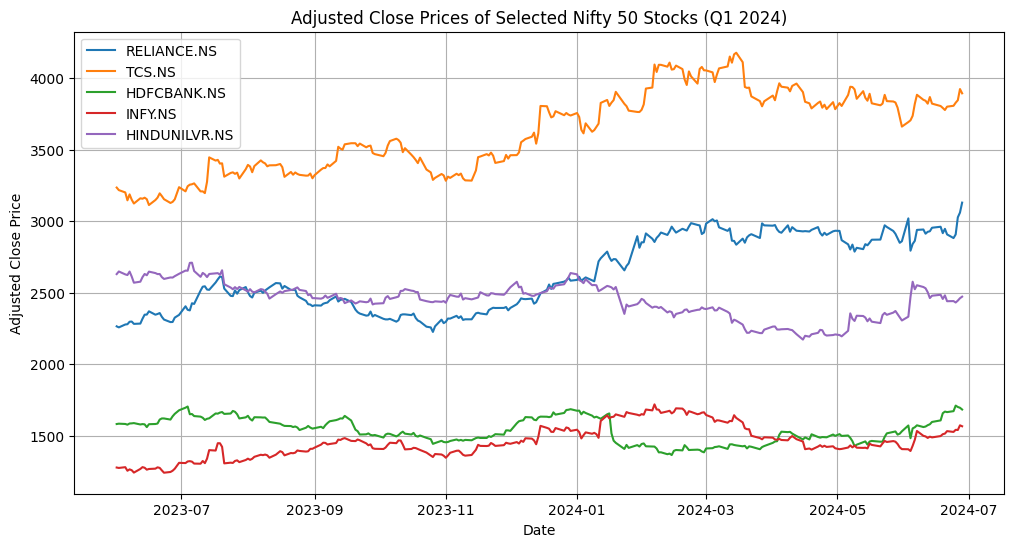

In [ ]:
# Example preprocessing (calculate daily returns)
daily_returns = multi_index_df.groupby('Ticker')['adjclose'].pct_change()

# Visualization: Plot adjusted close prices for selected tickers
plt.figure(figsize=(12, 6))
for ticker in ['RELIANCE.NS', 'TCS.NS', 'HDFCBANK.NS', 'INFY.NS', 'HINDUNILVR.NS']:
    plt.plot(multi_index_df.loc[ticker].index, multi_index_df.loc[ticker]['adjclose'], label=ticker)

plt.title('Adjusted Close Prices of Selected Nifty 50 Stocks (Q1 2024)')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.grid(True)
plt.show()



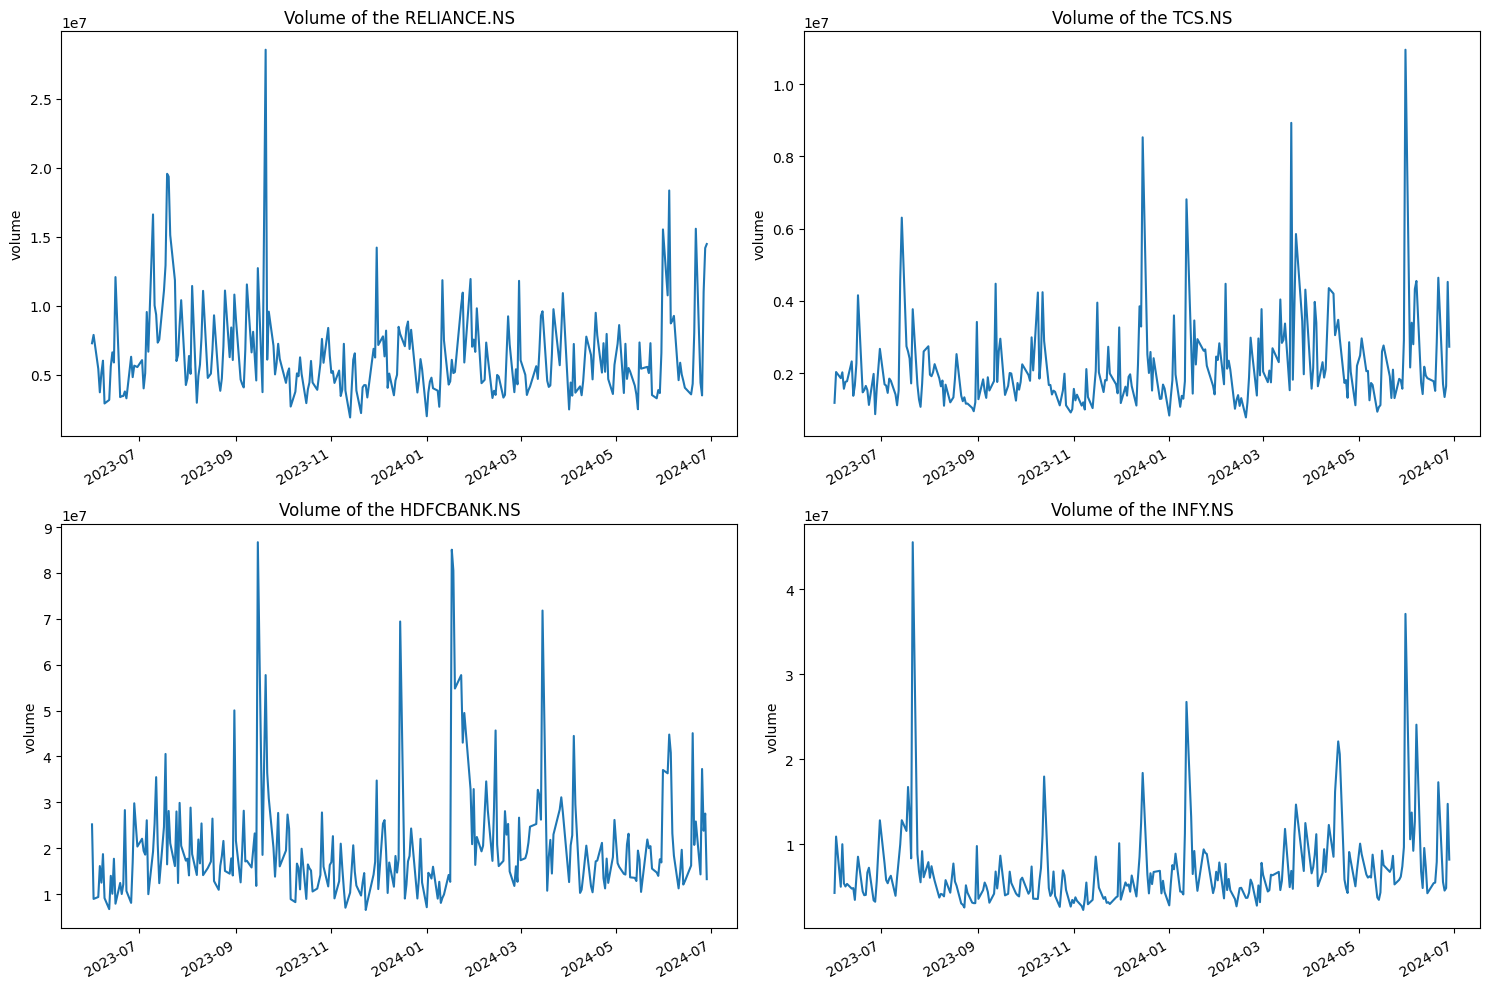

In [ ]:
# List of selected tickers
tickers = ['RELIANCE.NS', 'TCS.NS', 'HDFCBANK.NS', 'INFY.NS']

# Initialize the figure
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=0.95, bottom=0.05, hspace=0.3, wspace=0.2)

# Loop through each ticker and create subplots
for i, ticker in enumerate(tickers, 1):
    plt.subplot(2, 2, i)  # Create a 2x2 grid of subplots
    data = multi_index_df.loc[ticker]['volume']  # Select data for the current ticker
    data.plot()
    plt.ylabel('volume')  # Label for y-axis
    plt.xlabel(None)  # Remove x-axis label
    plt.title(f"Volume of the {ticker}")  # Title for each subplot

# Adjust the layout so the subplots fit well
plt.tight_layout()
plt.show()

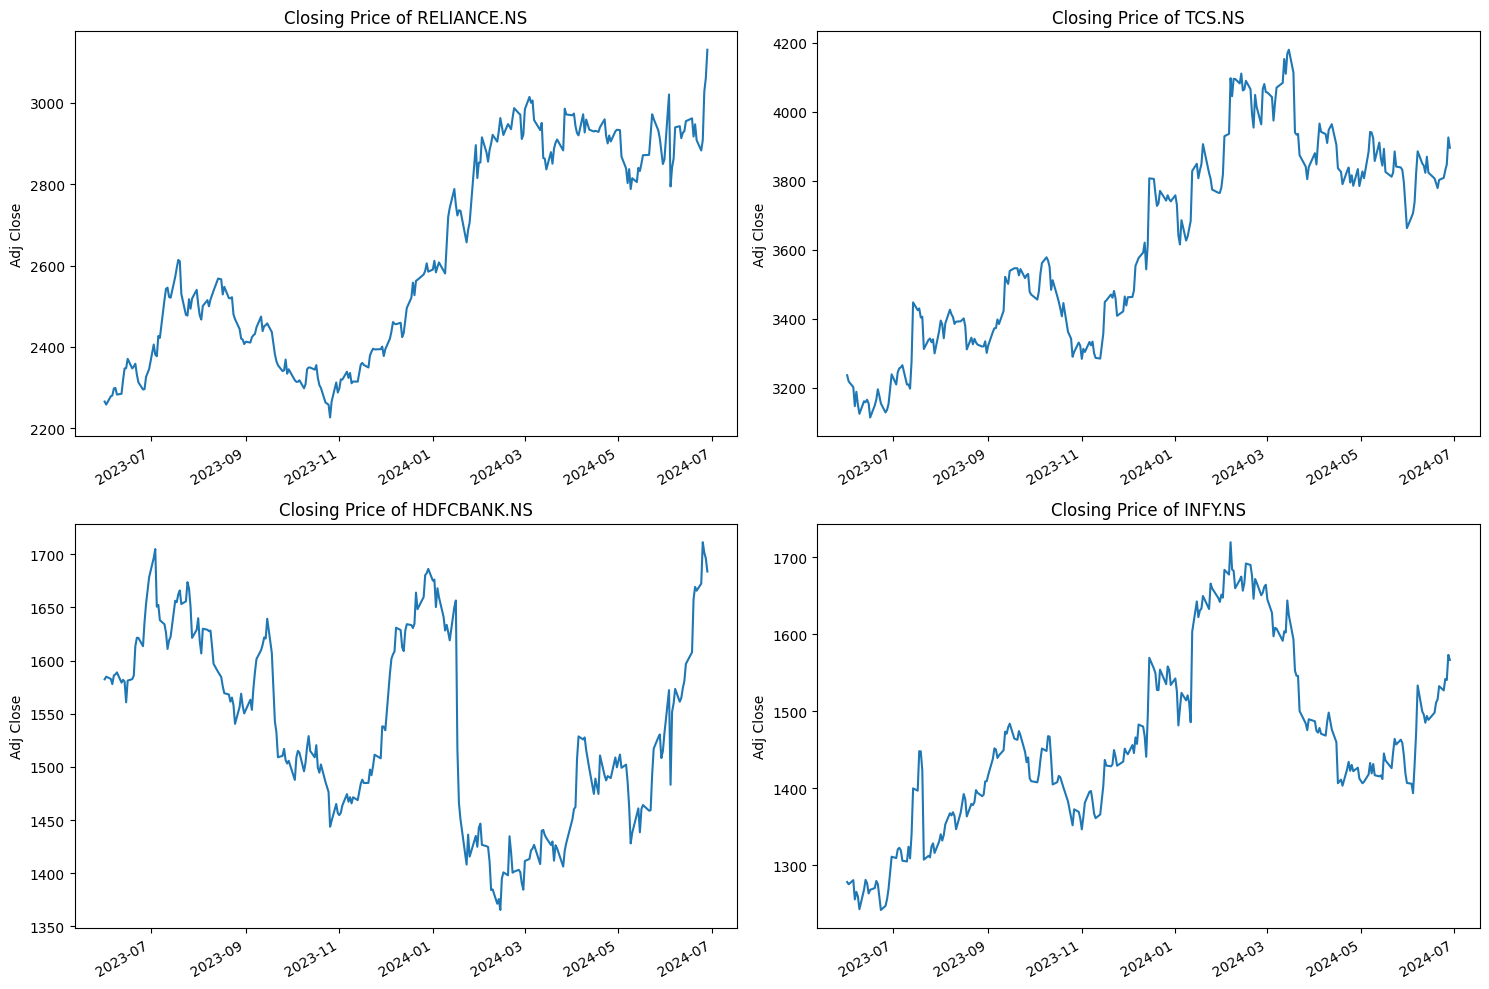

In [ ]:
# Initialize the figure
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=0.95, bottom=0.05, hspace=0.3, wspace=0.2)

# Loop through each ticker and create subplots
for i, ticker in enumerate(tickers, 1):
    plt.subplot(2, 2, i)  # Create a 2x2 grid of subplots
    data = multi_index_df.loc[ticker]['adjclose']  # Select data for the current ticker
    data.plot()
    plt.ylabel('Adj Close')  # Label for y-axis
    plt.xlabel(None)  # Remove x-axis label
    plt.title(f"Closing Price of {ticker}")  # Title for each subplot

# Adjust the layout so the subplots fit well
plt.tight_layout()
plt.show()

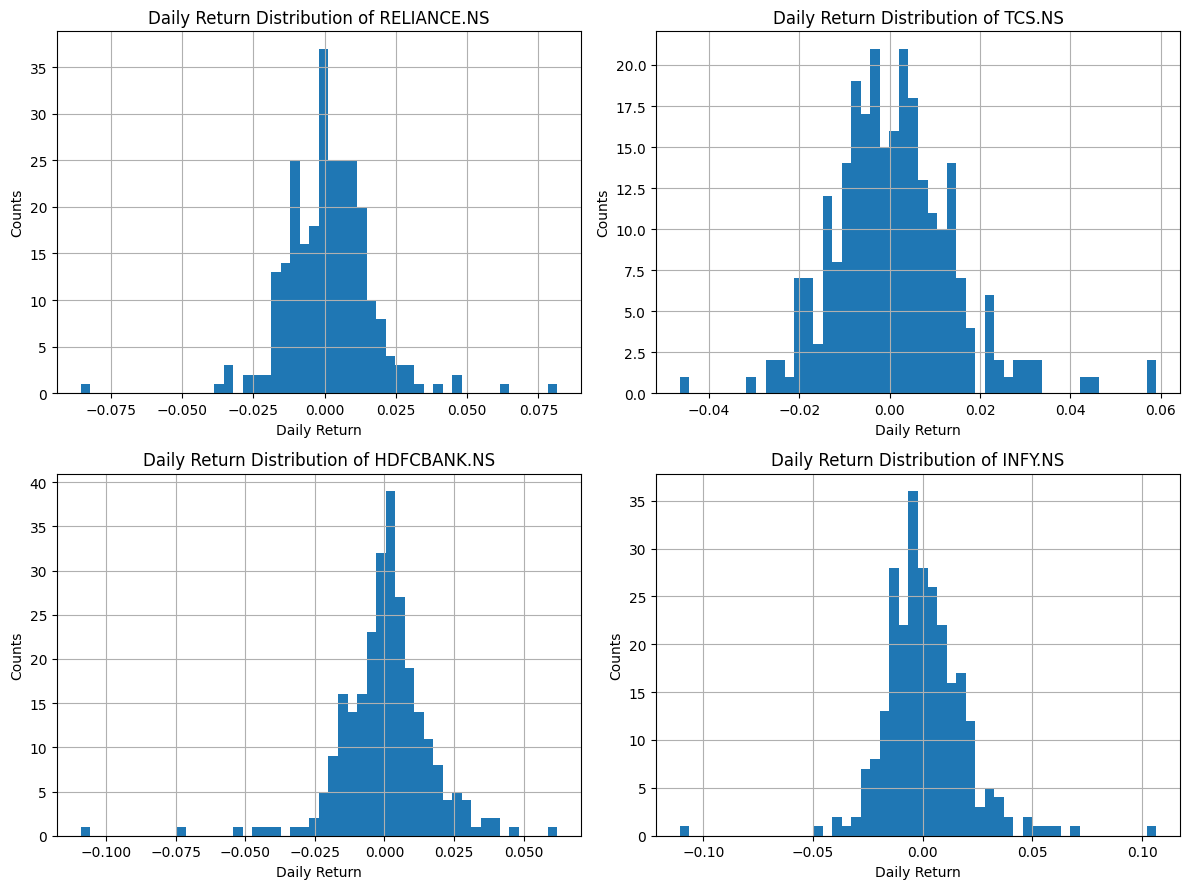

In [ ]:
# Handle missing values with forward fill
multi_index_df = multi_index_df.ffill()

# Calculate daily returns
multi_index_df['Daily Return'] = multi_index_df.groupby('Ticker')['adjclose'].transform(lambda x: x.pct_change())

# Initialize the figure
plt.figure(figsize=(12, 9))
plt.subplots_adjust(top=0.95, bottom=0.05, hspace=0.3, wspace=0.2)

# Loop through each ticker and create subplots for daily return histograms
for i, ticker in enumerate(tickers, 1):
    plt.subplot(2, 2, i)
    data = multi_index_df.loc[ticker]['Daily Return']  # Select daily return data for the current ticker
    data.hist(bins=50)  # Plot histogram of daily returns
    plt.xlabel('Daily Return')
    plt.ylabel('Counts')
    plt.title(f'Daily Return Distribution of {ticker}')

# Adjust the layout so the subplots fit well
plt.tight_layout()
plt.show()